<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Neural Network Framework (Keras)

## *Data Science Unit 4 Sprint 2 Assignmnet 3*

## Use the Keras Library to build a Multi-Layer Perceptron Model on the Boston Housing dataset

- The Boston Housing dataset comes with the Keras library so use Keras to import it into your notebook. 
- Normalize the data (all features should have roughly the same scale)
- Import the type of model and layers that you will need from Keras.
- Instantiate a model object and use `model.add()` to add layers to your model
- Since this is a regression model you will have a single output node in the final layer.
- Use activation functions that are appropriate for this task
- Compile your model
- Fit your model and report its accuracy in terms of Mean Squared Error
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Run this same data through a linear regression model. Which achieves higher accuracy?
- Do a little bit of feature engineering and see how that affects your neural network model. (you will need to change your model to accept more inputs)
- After feature engineering, which model sees a greater accuracy boost due to the new features?

## Imports and Data

In [4]:
import tensorflow as tf
from keras.datasets import boston_housing

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [182]:
# load data 
(X_train, y_train), (X_test, y_test) = boston_housing.load_data()

# Normalize data
X_train = tf.keras.utils.normalize(X_train, axis=1)
X_test = tf.keras.utils.normalize(X_test, axis=1)

In [183]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((404, 13), (404,), (102, 13), (102,))

In [190]:
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.002412,0.000000,0.015930,0.0,0.001053,0.012020,0.179454,0.007783,0.007828,0.600788,0.041096,0.776719,0.036634
1,0.000041,0.154587,0.003804,0.0,0.000778,0.014260,0.029418,0.011749,0.003748,0.652077,0.027545,0.740857,0.005827
2,0.006345,0.000000,0.023446,0.0,0.000817,0.006438,0.129538,0.001726,0.031089,0.862723,0.026167,0.486441,0.004223
3,0.000087,0.000000,0.011339,0.0,0.001125,0.013190,0.075376,0.013077,0.010924,0.489400,0.044133,0.867155,0.017500
4,0.004743,0.000000,0.023248,0.0,0.000916,0.008189,0.113541,0.003297,0.030826,0.855411,0.025945,0.502753,0.018816


## Keras Model

In [248]:
# Instantiate Model
model = Sequential()

# Input Layer
model.add(Dense(1, input_dim=13, activation='linear'))

# # Hidden Layers
# model.add(Dense(1, activation='sigmoid')) 
# model.add(Dense(1, activation='sigmoid')) 
# model.add(Dense(1, activation='sigmoid')) 

# Output Layer
model.add(Dense(1, activation='linear'))

#Compile
model.compile(loss='mean_squared_error',
                    optimizer='adam',
                    metrics=['mean_squared_error'])

model.summary()

# Hyper Parameters
batch_size = 60
epochs = 25000

# Fit Model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

# Test Accuracy (Mean Squared Error)
scores = model.evaluate(X_test, y_test)
print(f'{model.metrics_names[1]}: {scores[1]}')

# mse=30 w/ 10K epochs + 3 hidden layers
# mse=23 w/ 25K epochs + 0 hidden layers

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_161 (Dense)            (None, 1)                 14        
_________________________________________________________________
dense_162 (Dense)            (None, 1)                 2         
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________
102/102 [==============================] - 0s 3ms/sample - loss: 23.2663 - mean_squared_error: 23.2663
mean_squared_error: 23.266252517700195


## Graph accuracy

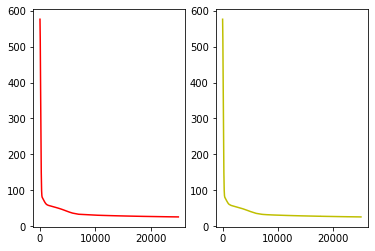

In [250]:
fig, ((ax1, ax2)) = plt.subplots(1, 2)

ax1.plot(history.history['loss'], color = 'r')
ax2.plot(history.history['mean_squared_error'], color = 'y')

## Try with Linear Regression

In [251]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Load Data
(X_train, y_train), (X_test, y_test) = boston_housing.load_data()

# Normalize Data
X_train = tf.keras.utils.normalize(X_train, axis=1)
X_test = tf.keras.utils.normalize(X_test, axis=1)

# Instantiate Model
model = LinearRegression()

# Fit Model
model.fit(X_train,y_train)

# Predict
y_pred = model.predict(X_test)

# Accuracy
mse = mean_squared_error(y_test, y_pred)
print('The mean squared error is:', mse)

The mean squared error is: 18.16551049349648


## Use the Keras Library to build an image recognition network using the Fashion-MNIST dataset (also comes with keras)

- Load and preprocess the image data similar to how we preprocessed the MNIST data in class.
- Make sure to one-hot encode your category labels
- Make sure to have your final layer have as many nodes as the number of classes that you want to predict.
- Try different hyperparameters. What is the highest accuracy that you are able to achieve.
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Remember that neural networks fall prey to randomness so you may need to run your model multiple times (or use Cross Validation) in order to tell if a change to a hyperparameter is truly producing better results.

In [5]:
from tensorflow.keras.datasets import fashion_mnist

# Load data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# 0 - T-shirt
# 1 - Trousers
# 2 - Pullover
# 3 - Skirt
# 4 - Coat
# 5 - Sandal
# 6 - Shirt
# 7 - Sneaker
# 8 - Bag
# 9 - Boot

In [6]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

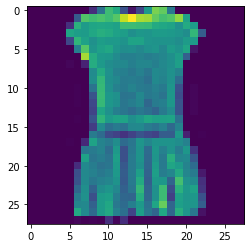

In [7]:
plt.imshow(X_train[3])

In [8]:
# Reshape the data - Flatten?
# X_train = X_train.reshape(60000, 784)
# X_test = X_test.reshape(10000, 784)

from tensorflow.keras.utils import normalize
# Normalize the Data
X_train = normalize(X_train)
X_test = normalize(X_test)

In [14]:
from keras.layers import Flatten

# Instantiate Model
model = tf.keras.models.Sequential()

# Input Layer
model.add(tf.keras.layers.Flatten())
model.add(Dense(128, input_dim=784, activation='relu'))

# Hidden Layers
model.add(Dense(128, activation='relu')) 
model.add(Dense(128, activation='relu')) 

# Output
model.add(Dense(10,activation='softmax'))

# Compile
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Hyperparameters
batch_size = 64
epochs = 100

# Fit
history = model.fit(X_train, y_train, epochs=epochs, validation_split=.1)

# Test Accuracy
scores = model.evaluate(X_test, y_test)
print(f'{model.metrics_names[1]}: {scores[1]*100}')

Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 8s 156us/sample - loss: 0.4882 - acc: 0.8219 - val_loss: 0.3833 - val_acc: 0.8572
Epoch 2/100
54000/54000 [==============================] - 7s 133us/sample - loss: 0.3588 - acc: 0.8669 - val_loss: 0.3463 - val_acc: 0.8687
Epoch 3/100
54000/54000 [==============================] - 6s 115us/sample - loss: 0.3214 - acc: 0.8806 - val_loss: 0.3461 - val_acc: 0.8738
Epoch 4/100
54000/54000 [==============================] - 7s 137us/sample - loss: 0.2985 - acc: 0.8891 - val_loss: 0.3610 - val_acc: 0.8690
Epoch 5/100
54000/54000 [==============================] - 6s 119us/sample - loss: 0.2816 - acc: 0.8933 - val_loss: 0.3748 - val_acc: 0.8657
Epoch 6/100
54000/54000 [==============================] - 6s 116us/sample - loss: 0.2677 - acc: 0.8986 - val_loss: 0.3215 - val_acc: 0.8840
Epoch 7/100
54000/54000 [==============================] - 6s 109us/sample - loss: 0.2571 - acc: 0.9024 -

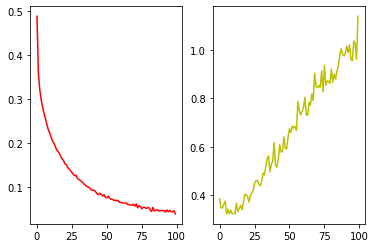

In [18]:
fig, ((ax1, ax2)) = plt.subplots(1, 2)

ax1.plot(history.history['loss'], color = 'r')
ax2.plot(history.history['val_loss'], color = 'y')

## Stretch Goals:

- Use Hyperparameter Tuning to make the accuracy of your models as high as possible. (error as low as possible)
- Use Cross Validation techniques to get more consistent results with your model.
- Use GridSearchCV to try different combinations of hyperparameters. 
- Start looking into other types of Keras layers for CNNs and RNNs maybe try and build a CNN model for fashion-MNIST to see how the results compare.